# NP_hard_Algorithm_Project: The Big Heist

## Description

Given list of bank locations, how much money each one holds and the time it would take to rob each one, you need to apply your hard-won algorithm knowledge to make as much profit as possible! _I bet you didn't think that data science could be this profitable!_

You will design and write a solution to an NP-Had algorithm to this problem

You will need to apply all the knowledge learned up to now to get the best possible result at this task given a large list of banks and 3 minutes to run your algorithm.

The list of banks is in `data/bank_data.csv`. This is what the data looks like.

```csv
id, x_coordinate, y_coordinate, money, time (hr)
0, 11.4, 3.3, 5000, 0.6
1, 6.9, 7.1, 15000, 0.3
2, 1.4, 13.2, 900, 1.1
```

You have **24 hours** to make as much money as possible and then escape.

## Rules

- Your run can start anywhere on the map but it has to end at the **helicopter escape zone**: coordinates (0,0)
    - If you try to rob too many banks and can't get to the helicopter in 24 hours, you get caught and go to jail.

- Your solution is a list or array of integers (eg. `[580, 433, 24, 998]`) where the numbers are the IDs of each banks. The ID of each bank is their index (their row index).

- You travel between banks at 30 km/h. You have to travel from one bank to the next!
    - Remember the formula to calculate the distance between two points.
    - The coordinates are in kilometers.
        - So (1, 1) and (1, 2) are one kilometer apart. 
        - This would take 1 / 30 hour = 2 minutes to travel

- Your solution should be an approximative/heuristic algorithm
    - This problem is NP-Hard, you won't find a fast enough algorithm that has the perfect solution
    - It doesn't need to find the best solution
    - Find the best solution you can!

- Your solution has to run on a common laptop in under 3 minutes for the 10,000 cities dataset
    - You can use everything you want to achieve this:
        - Use numpy, pandas, functions, algorithms
        - You can use parallelism
        - Use optimied libraries (pandas, numba, scipy, etc.)
    - Test your code on **small subsets** of the data so they run fast
        - Then scale your code up to bigger chunks of the data

- Your input is a pandas dataframe with the bank data. Your output is a list of bank IDs in order that you rob them:

```python
# example
df = pd.read_csv('bank_data.csv')
robber_algorithm(df)

# Output is a list of bank IDs
[OUTPUT] --> [664, 2341, 26, 998, 9583, 24, 1, 444, 6783]

## FIRST APPROACH

With this approach, I'm checking the top 10%+- in terms of both money and time (specifically, the top 10%+- that takes less time) and then creating a dataframe. Afterward, I'm using the new dataframe to create a matrix to search for the most optimal path. I'm using a for loop and the checking solution provided in the code in order to find the most optimal combination of time and money quantile.

In [3]:
def distance(x1, y1, x2, y2):
    return math.hypot(x2 - x1, y2 - y1)

def check_solution(travel_list, df, speed=30.):
    """
    Check a bank robber algorithm solution
    
    input:
    ------
    travel_list: a list of integers
        Your solution to the bank robber problem
        Bank IDs are row indeces into the df passed
    df: pd.DataFrame
        The algorithm input formatted dataframe 
        (id,x_coordinate,y_coordinate,money,time (hr))
    speed: float
        The km/h speed of travel
    """
    t_remaining = 24.
    score = 0.
    assert len(travel_list) == len(set(travel_list)), (
        "Your travel list must have unique IDs!"
    )
    prev = travel_list[0]
    for e in travel_list:
        row = df.iloc[e]
        score += row['money']
        t_remaining -= row['time (hr)']
        dist = distance(
            row['x_coordinate'], row['y_coordinate'],
            df.iloc[prev]['x_coordinate'],
            df.iloc[prev]['y_coordinate'],
        )
        t_remaining -= dist / speed
        prev = e
    assert t_remaining >= 0, (
        f"Used more than 24h! Time left: {t_remaining}"
    )
    # still gotta get to (0, 0)
    dist = distance(row['x_coordinate'],row['y_coordinate'],0,0)
    final_t = t_remaining - (dist / speed)
    assert final_t >= 0, (
        f"Not enough time to get to helicopter!\n"
        f"Time left after last bank: {t_remaining}\n"
        f"Distance to (0,0) helipad: {dist}\n"
    )
    print(f"Time Remaining: {final_t}")
    return score

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix
from scipy.optimize import linear_sum_assignment
import math

df = pd.read_csv('bank_data.csv')

threshold_time_values = [0.08, 0.09, 0.1, 0.11, 0.12]
threshold_values = [0.88, 0.89, 0.9, 0.91, 0.92]

best_combinations = []

for i in threshold_time_values:
    for j in threshold_values:
        threshold_time = df['time (hr)'].quantile(i)
        threshold = df['money'].quantile(j)
        
        top_percent = df[df['money'] >= threshold]
        grouped = top_percent.groupby('money')['time (hr)'].min()
        sorted_grouped = grouped.sort_values(ascending=True)
        result = df[df['money'].isin(sorted_grouped.index)].sort_values('time (hr)')
        result.reset_index(drop=True, inplace=True)
        
        df2 = result[result['time (hr)'] < threshold_time].copy()
        df2.loc[0] = [0, 0, 0, 0, 0]
        
        x_coordinates = df2['x_coordinate'].values
        y_coordinates = df2['y_coordinate'].values
        coordinates = np.column_stack((x_coordinates, y_coordinates))
        
        dist_matrix = distance_matrix(coordinates, coordinates)
        
        row_ind, col_ind = linear_sum_assignment(dist_matrix)
        
        path_order = col_ind.tolist()
        
        final_point_index = np.where((x_coordinates == 0) & (y_coordinates == 0))[0][0]
        path_order.append(final_point_index)
        
        order_of_indices = df2.index[path_order].tolist()
        
        if order_of_indices[-1] == 0:
            order_of_indices.pop()
        
        best_order_of_indices = df2['id'].iloc[order_of_indices].tolist()
        ideal_order = best_order_of_indices[::-1]
        
        money_sum = df2['money'].sum()
        
        best_combinations.append((i, j, ideal_order, money_sum))

best_combinations.sort(key=lambda x: x[3], reverse=True)

for combination in best_combinations:
    i, j, ideal_order, money_sum = combination
    try:
        score = check_solution(ideal_order, df, speed=30.0)
        print(f"Combination (i: {i}, j: {j})")
        print(f"Best Bank ID's: {ideal_order}")
        print(f"Score: {score}")
        print()
    except AssertionError as e:
        print(f"Assertion Error: {str(e)}")
        print("Continuing to next combination...")
        print()
        continue


Assertion Error: Used more than 24h! Time left: -11.479513783329878
Continuing to next combination...

Assertion Error: Used more than 24h! Time left: -7.220073086465896
Continuing to next combination...

Assertion Error: Used more than 24h! Time left: -6.635012940714549
Continuing to next combination...

Assertion Error: Used more than 24h! Time left: -4.518169839646488
Continuing to next combination...

Assertion Error: Used more than 24h! Time left: -2.6047977100057693
Continuing to next combination...

Assertion Error: Used more than 24h! Time left: -3.1737737943233437
Continuing to next combination...

Assertion Error: Used more than 24h! Time left: -1.4850247416447544
Continuing to next combination...

Assertion Error: Used more than 24h! Time left: -0.5871449966921418
Continuing to next combination...

Time Remaining: 0.7532825056184962
Combination (i: 0.1, j: 0.89)
Best Bank ID's: [4214, 6934, 7625, 2344, 5572, 2162, 5381, 5440, 8125, 6281, 664, 7265, 4234, 4742, 8288, 1447, 63

### checking solution

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix
from scipy.optimize import linear_sum_assignment
import math

df = pd.read_csv('bank_data.csv')

best_order_of_indices = []

for i in threshold_time_values:
    for j in threshold_values:
        
        threshold_time = df['time (hr)'].quantile(0.1)
        threshold = df['money'].quantile(0.89)
        
        
        top_percent = df[df['money'] >= threshold]
        grouped = top_percent.groupby('money')['time (hr)'].min()
        sorted_grouped = grouped.sort_values(ascending=True)
        result = df[df['money'].isin(sorted_grouped.index)].sort_values('time (hr)')
        result.reset_index(drop=True, inplace=True)

        
        df2 = result[result['time (hr)'] < threshold_time].copy()
        
        df2.loc[0] = [0, 0, 0, 0, 0]

        x_coordinates = df2['x_coordinate'].values
        y_coordinates = df2['y_coordinate'].values
        coordinates = np.column_stack((x_coordinates, y_coordinates))

        dist_matrix = distance_matrix(coordinates, coordinates)

        row_ind, col_ind = linear_sum_assignment(dist_matrix)

        path_order = col_ind.tolist()

        final_point_index = np.where((x_coordinates == 0) & (y_coordinates == 0))[0][0]
        path_order.append(final_point_index)

        order_of_indices = df2.index[path_order].tolist()

        if order_of_indices[-1] == 0:
            order_of_indices.pop()

        best_order_of_indices = df2['id'].iloc[order_of_indices].tolist()
        
        check_ideal_order = best_order_of_indices[::-1]
        
print(f"Best Bank ID's: { check_ideal_order}")

Best Bank ID's: [4214, 6934, 7625, 2344, 5572, 2162, 5381, 5440, 8125, 6281, 664, 7265, 4234, 4742, 8288, 1447, 6317, 7769, 2, 488, 4610, 5836, 757, 2458, 8909, 4494, 2226, 7494, 781, 7531, 557, 2590, 2626, 6156, 7907, 6169, 7772, 4492, 4807, 6535, 9908, 5296, 1976, 5155, 4627, 1455, 4983, 1372, 7583, 7689, 5622, 9049, 3026, 5356, 6216, 5166, 3297, 7087, 517, 7595, 5295, 299, 8231, 3516, 7665, 4906, 2190, 9378, 6104, 8525, 3193, 4789, 4287, 5610, 4696, 2346, 7064, 9653, 6740, 8287, 7074, 2331, 433, 8469, 6468, 1757, 7560, 5135, 487, 3466, 8562, 7544, 6097, 9241, 4762, 5933, 0]


In [6]:
check_solution(check_ideal_order, df, speed=30.)

Time Remaining: 0.7532825056184962


7571300.0

## SECOND APPROACH

This second approach has the potential to yield more money if the robbery is carried out by many individuals.

First, we select the banks that have more money than the average and do the same but to a lesser extent for the time, meaning that we select the banks that take less time than the average.

After we have a newly filtered dataframe, we divide it into four quadrants, which are divided by x=0 and y=0. After creating the quadrants, we select the one with the most money, and then modify the code with a .quantile to be able to rob as many banks as possible within 24 hours.

If we were to assign one person or team to each of the four quadrants, we would be able to achieve a score of $15,313,056 for the entire filtered dataframe, which is more than the first approach.

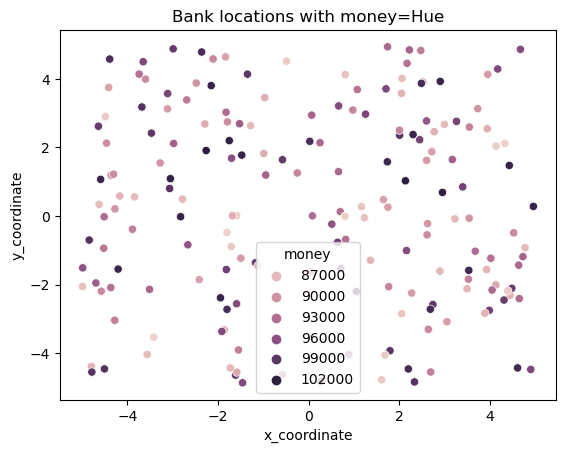

Money in Top Right Quadrant: 4581700
Money in Top Left Quadrant: 4564400
Money in Bottom Right Quadrant: 4808200
Money in Bottom Left Quadrant: 3446900


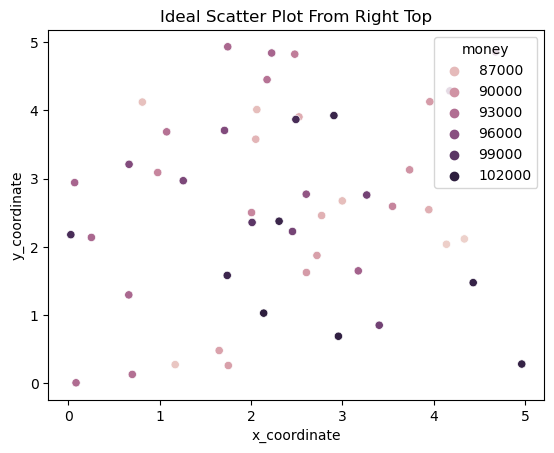

/tmp/ipykernel_39677/3807286494.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sideal_df.loc[0] = [0,0,0,0,0]


In [7]:

sdf = pd.read_csv('bank_data.csv') 
savg_money = sdf['money'].mean()
savg_time = sdf['time (hr)'].mean()


sdf2 = sdf[(sdf['money'] > savg_money ) & (sdf['time (hr)'] < savg_time)]

sthreshold = sdf2['money'].quantile(0.88)
stop_10_percent = sdf2[sdf2['money'] >= sthreshold]
sgrouped = stop_10_percent.groupby('money')['time (hr)'].min()
ssorted_grouped = sgrouped.sort_values(ascending=True)
sresult = sdf2[sdf2['money'].isin(ssorted_grouped.index)].sort_values('time (hr)')

sns.scatterplot(data=sresult, x='x_coordinate', y='y_coordinate', hue='money')
plt.xlabel('x_coordinate')
plt.ylabel('y_coordinate')
plt.title('Bank locations with money=Hue')
plt.show()


top_right = (sresult['x_coordinate'] >= 0) & (sresult['y_coordinate'] >= 0)
top_left = (sresult['x_coordinate'] <= 0) & (sresult['y_coordinate'] >= 0)
bottom_right = (sresult['x_coordinate'] >= 0) & (sresult['y_coordinate'] <= 0)
bottom_left = (sresult['x_coordinate'] <= 0) & (sresult['y_coordinate'] <= 0)


money_top_right = sresult.loc[top_right, 'money'].sum()
money_top_left = sresult.loc[top_left, 'money'].sum()
money_bottom_right = sresult.loc[bottom_right, 'money'].sum()
money_bottom_left = sresult.loc[bottom_left, 'money'].sum()


print("Money in Top Right Quadrant:", money_top_right)
print("Money in Top Left Quadrant:", money_top_left)
print("Money in Bottom Right Quadrant:", money_bottom_right)
print("Money in Bottom Left Quadrant:", money_bottom_left)

sideal_df = sresult[(sresult['x_coordinate'] >= 0 ) & (sresult['y_coordinate'] >= 0)]

sns.scatterplot(data=sideal_df, x='x_coordinate', y='y_coordinate', hue='money')
plt.xlabel('x_coordinate')
plt.ylabel('y_coordinate')
plt.title('Ideal Scatter Plot From Right Top')
plt.show()

sideal_df.loc[0] = [0,0,0,0,0]

sx_coordinates = sideal_df['x_coordinate'].values
sy_coordinates = sideal_df['y_coordinate'].values


scoordinates = np.column_stack((sx_coordinates, sy_coordinates))


sdist_matrix = distance_matrix(scoordinates, scoordinates)

srow_ind, scol_ind = linear_sum_assignment(sdist_matrix)

spath_order = scol_ind.tolist()

sfinal_point_index = np.where((sx_coordinates == 0) & (sy_coordinates == 0))[0][0]
spath_order.append(sfinal_point_index)

sorder_of_indices = sideal_df.index[spath_order].tolist()

if sorder_of_indices[-1] == 0:
    sorder_of_indices.pop()

### checking solution

In [8]:
def distance(x1, y1, x2, y2):
    return math.hypot(x2 - x1, y2 - y1)

def check_solution(travel_list, df, speed=30.):
    """
    Check a bank robber algorithm solution
    
    input:
    ------
    travel_list: a list of integers
        Your solution to the bank robber problem
        Bank IDs are row indeces into the df passed
    df: pd.DataFrame
        The algorithm input formatted dataframe 
        (id,x_coordinate,y_coordinate,money,time (hr))
    speed: float
        The km/h speed of travel
    """
    t_remaining = 24.
    score = 0.
    assert len(travel_list) == len(set(travel_list)), (
        "Your travel list must have unique IDs!"
    )
    prev = travel_list[0]
    for e in travel_list:
        row = df.iloc[e]
        score += row['money']
        t_remaining -= row['time (hr)']
        dist = distance(
            row['x_coordinate'], row['y_coordinate'],
            df.iloc[prev]['x_coordinate'],
            df.iloc[prev]['y_coordinate'],
        )
        t_remaining -= dist / speed
        prev = e
    assert t_remaining >= 0, (
        f"Used more than 24h! Time left: {t_remaining}"
    )
    # still gotta get to (0, 0)
    dist = distance(row['x_coordinate'],row['y_coordinate'],0,0)
    final_t = t_remaining - (dist / speed)
    assert final_t >= 0, (
        f"Not enough time to get to helicopter!\n"
        f"Time left after last bank: {t_remaining}\n"
        f"Distance to (0,0) helipad: {dist}\n"
    )
    print(f"Time Remaining: {final_t}")
    return score

In [9]:
check_solution(sorder_of_indices,sdf)

Time Remaining: 0.5008156027571717


4611400.0